In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
from tqdm import tqdm
from collections import defaultdict

import pandas as pd
import os 
from glob import glob
import pickle

import numpy as np
import cv2

import albumentations

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset

In [4]:
import sys

sys.path.append('..')
from src.configs import config
from src.utils import visualisation as vs
from src.modules import dataset as ds
from src.modules import metrics as ms
from src.modules import augmentations as augs
from src.modules import learner as lrn
from src.modules import lr_scheduler as lrs

# from retinanet import model as retinanet
import src.models.retinanet.resnext
import src.models.retinanet.model
from src.models.retinanet import model as retinanet

%load_ext autoreload
%autoreload 2

In [5]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [6]:
labels = pd.read_csv(os.path.join(config.PATHS.CSV, 'labels.csv'))
folds = ds.get_folds(labels, config.PARAMS.NB_FOLDS)

In [7]:
def get_datagens(folds, fold):
    fold = ds.get_fold_split(folds, fold)
    train_dataset = ds.BBoxDataset(labels, fold[0], augmentations=augs.Augmentation())
    valid_dataset = ds.BBoxDataset(labels, fold[1])
    vtrain_dataset = ds.BBoxDataset(labels, fold[0])

    train_datagen = DataLoader(train_dataset, batch_size=config.PARAMS.BATCH_SIZE, shuffle=True, collate_fn=ds.bbox_collater)
    valid_datagen = DataLoader(valid_dataset, batch_size=config.PARAMS.BATCH_SIZE, shuffle=False, collate_fn=ds.bbox_collater)
    vtrain_datagen = DataLoader(vtrain_dataset, batch_size=config.PARAMS.BATCH_SIZE, shuffle=True, collate_fn=ds.bbox_collater)
    return train_datagen, valid_datagen, vtrain_datagen

In [8]:
train_datagen, valid_datagen, vtrain_datagen = get_datagens(folds, 0)

In [9]:
for data in train_datagen:
    break

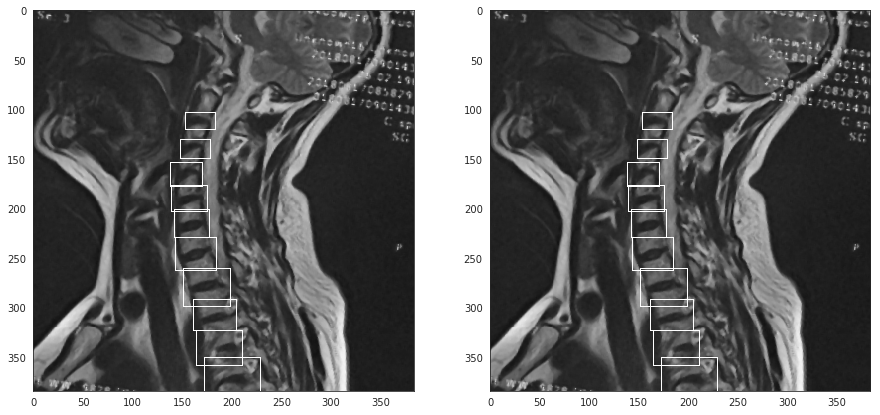

In [10]:
data = train_datagen.dataset[55]
img = vs.visualize_bboxes(data, data, {1: 'normal', 0: 'pathology'})

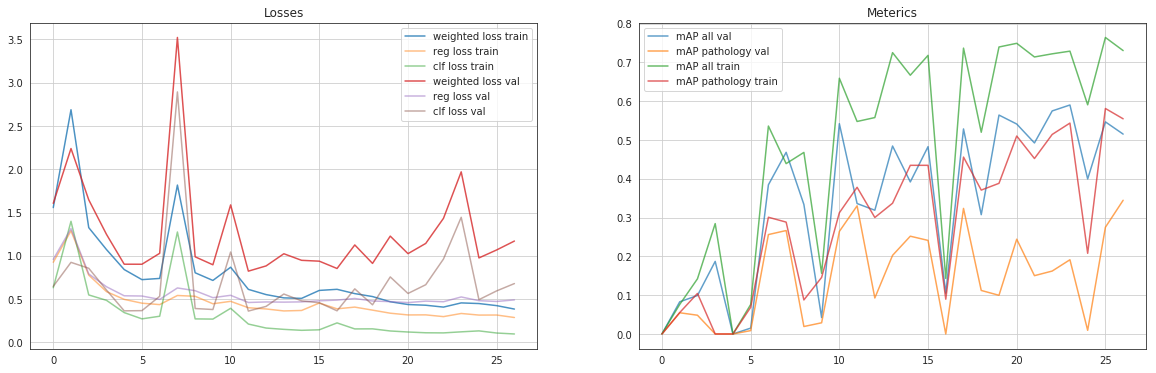

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


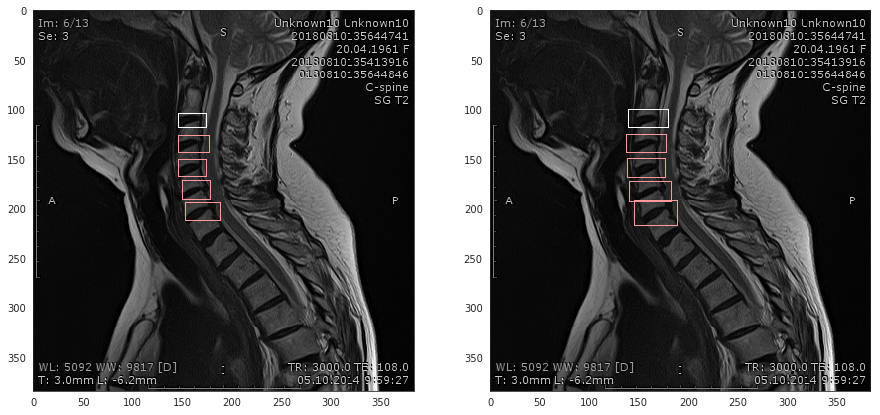

  0%|          | 0/30 [00:00<?, ?it/s]

Saved in ../data/models/retinanet34/fold_0_checkpoint.epoch_26:
Epoch: 27


 25%|██▍       | 72/292 [00:02<00:06, 31.65it/s]

In [ ]:
for fold in range(config.PARAMS.NB_FOLDS):
    train_datagen, valid_datagen, vtrain_datagen = get_datagens(folds, fold)

    focal_loss = retinanet.FocalLoss(iou_lower=.3, iou_upper=.4)
    model = retinanet.resnet34(num_classes=2, focal_loss=focal_loss, pretrained=True, single_channel=True, make_clf=False)

    opt = torch.optim.Adam(model.parameters(), lr=5e-4)
    model = lrn.get_model(model, devices=config.PARAMS.CUDA_DEVICES)

    lr_scheduler = lrs.CosinePiloExt(opt, multiplier=.1, coeff=config.PARAMS.EXP_GAMMA, steps_per_epoch=len(train_datagen) * 8)
    learner = lrn.RetinaLearner(model, opt)

    history = defaultdict(list)
    mval = 0
    for i in range(100):

        print('Epoch: {}'.format(i))
        learner.train_on_epoch(train_datagen, lr_scheduler=lr_scheduler)
        lr_scheduler.step()
        el = learner.validate(vtrain_datagen)
        metr = ms.estimate_pred(el)
        history['train'].append(metr)

        el = learner.validate(valid_datagen)
        metr = ms.estimate_pred(el)
        history['valid'].append(metr)

        clear_output(wait=True)
        vs.plot_losses(history)
        vs.visualise_pred(el[0])

        path = os.path.join(config.PATHS.MODELS, 'retinanet34', 'fold_{}_checkpoint.epoch_{}'.format(fold, '{}'))
        if metr['map_pathology'] > mval:
            mval = metr['map_pathology']
            learner.save(path.format(i))

    learner.save(path.format(i))
    pickle.dump(history, open(path.format('loss'), 'wb'))